In [2]:
import torch
import numpy as np
import h5py
import sys
from matplotlib import pyplot as plt
from matplotlib import colors
from astropy.table import Table
from matplotlib import mlab as mlab
from astroNN.shared.matplotlib import pylab_style
pylab_style(paper=True)

sys.path.append("..") # add higher direc to path
from xp_vae.model import ScatterVAE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Using %s' % device)
torch.cuda.empty_cache()

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] =r"\usepackage{xcolor} "

import matplotlib as mpl

Using cpu


## Load data from XP/APOGEE cross-match

In [6]:
APOGEE_XP_XMATCH_PATH = '../data/xp_apogee_cat.h5'
f = h5py.File(APOGEE_XP_XMATCH_PATH,'r')['__astropy_table__']

# flux normalization
g_flux = f['phot_g_mean_flux'][:,np.newaxis]
xp = f['coeffs']/g_flux
xp_err = f['coeff_errs']/g_flux

# standard normalization
norm = np.load('../data/apogee_norm.npz')
xp_norm = (xp - norm['mu']) / norm['sig']
xp_err_norm = xp_err / norm['sig']

# stellar labels + redenning
teff = f['TEFF']
logg = f['LOGG']
m_h = f['M_H']
logebv = np.log10(f['SFD_EBV'])

# errors
teff_err = f['TEFF_ERR']
logg_err = f['LOGG_ERR']
m_h_err = f['M_H_ERR']

# other data for cuts
bp_rp = f['GAIAEDR3_PHOT_BP_MEAN_MAG'] - f['GAIAEDR3_PHOT_RP_MEAN_MAG']
mean_mag = f['GAIAEDR3_PHOT_G_MEAN_MAG']
starflag = f['STARFLAG']
aspcapflag = f['ASPCAPFLAG']

## Create catalogs

In [8]:
# GOOD LABELS CATALOG
teff_cut = (teff/teff_err)>20
logg_cut = logg_err<.4
m_h_cut = m_h_err<.2
bp_rp_cut = (bp_rp > 0.) & (bp_rp < 4.)
mag_cut = (mean_mag > 6.) & (mean_mag < 17.5)
star_cut = starflag == 0

from astroNN.apogee import allstar, bitmask_boolean
aspcap_cut = ~bitmask_boolean(aspcapflag, [2, 3])[0]

good_idx = ( teff_cut & logg_cut & m_h_cut & bp_rp_cut & mag_cut & star_cut & aspcap_cut)
print('Size of full catalog is %s' % len(teff))
print('')

# GOOD LABELS CATALOG
print('Size of good labels catalog is %s' % sum(good_idx))
print('Good/full = %.2f' % (sum(good_idx)/len(teff)))
print('Teff cut removes %s stars' % sum(~teff_cut))
print('logg cut removes %s stars' % sum(~logg_cut))
print('[M/H] cut removes %s stars' % sum(~m_h_cut))
print('')

# PRISTINE LABELS CATALOG
teff_cut = (teff/teff_err)> 100
logg_cut = logg_err<.1
m_h_cut = m_h_err<.05
pristine_idx = ( teff_cut & logg_cut & m_h_cut & bp_rp_cut & mag_cut & star_cut & aspcap_cut)
print('Size of pristine labels catalog is %s' % sum(pristine_idx))
print('Pristine/full = %.2f' % (sum(pristine_idx)/len(teff)))
print('Teff cut removes %s stars' % sum(~teff_cut))
print('logg cut removes %s stars' % sum(~logg_cut))
print('[M/H] cut removes %s stars' % sum(~m_h_cut))

Size of full catalog is 502311

Size of good labels catalog is 202970
Good/full = 0.40
Teff cut removes 16028 stars
logg cut removes 43705 stars
[M/H] cut removes 32314 stars

Size of pristine labels catalog is 123804
Pristine/full = 0.25
Teff cut removes 273466 stars
logg cut removes 286191 stars
[M/H] cut removes 33769 stars


## Visualize stellar label cuts

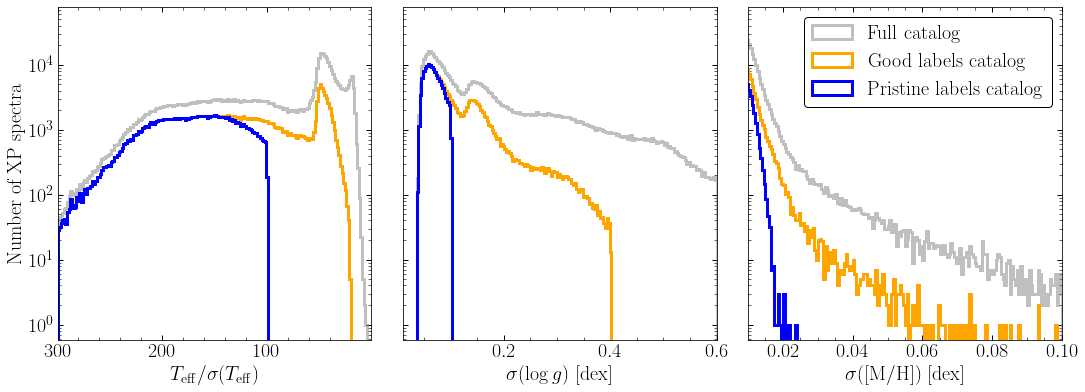

In [9]:
fig,ax = plt.subplots(1,3,figsize=(18,6),sharey=True)
n_bins = 201
lw = 3
plt.subplots_adjust(wspace=0.1)

# Teff
teff_SNR = 300
teff_bins = np.linspace(0,teff_SNR,n_bins)
ax[0].hist(teff/teff_err,bins=teff_bins,alpha=0.5,color='grey',label='Full catalog',histtype=u'step',lw=lw)
ax[0].hist((teff/teff_err)[good_idx],bins=teff_bins,color='orange',label='Good labels catalog',histtype=u'step',lw=lw)
ax[0].hist((teff/teff_err)[pristine_idx],bins=teff_bins,color='blue',label='Pristine labels catalog',histtype=u'step',lw=lw)
ax[0].set_xlim(teff_SNR,0.01)

# logg
logg_max_err = 0.6
logg_bins = np.linspace(0,logg_max_err,n_bins)
ax[1].hist(logg_err,bins=logg_bins,alpha=0.5,color='grey',histtype=u'step',lw=lw,label='Full catalog')
ax[1].hist(logg_err[good_idx],bins=logg_bins,color='orange',histtype=u'step',lw=lw,label='Good labels catalog')
ax[1].hist(logg_err[pristine_idx],bins=logg_bins,color='blue',histtype=u'step',lw=lw,label='Pristine labels catalog')
ax[1].set_xlim(0.01,logg_max_err)

# [M/H]
m_h_max_err = 0.1
m_h_bins = np.linspace(0,m_h_max_err,n_bins)
ax[2].hist(m_h_err,bins=m_h_bins,alpha=0.5,color='grey',histtype=u'step',lw=lw,label='Full catalog')
ax[2].hist(m_h_err[good_idx],bins=m_h_bins,color='orange',histtype=u'step',lw=lw,label='Good labels catalog')
ax[2].hist(m_h_err[pristine_idx],bins=m_h_bins,color='blue',histtype=u'step',lw=lw,label='Pristine labels catalog')
ax[2].set_xlim(0.01,m_h_max_err)

ax[0].set_ylabel('Number of XP spectra')
ax[0].set_xlabel(r'$T_{\rm eff}/\sigma(T_{\rm eff})$')
ax[1].set_xlabel(r'$\sigma(\log g)$ [dex]')
ax[2].set_xlabel(r'$\sigma(\rm [M/H])$ [dex]')

leg = ax[2].legend(framealpha=1,loc='upper right',fontsize=20)
leg.get_frame().set_edgecolor('k')

for axi in ax.flatten():
    axi.set_yscale('log')

plt.savefig('../figures/catalog_cuts.png',dpi=400,bbox_inches='tight')
plt.show()

## Visualize catalogs in Kiel space

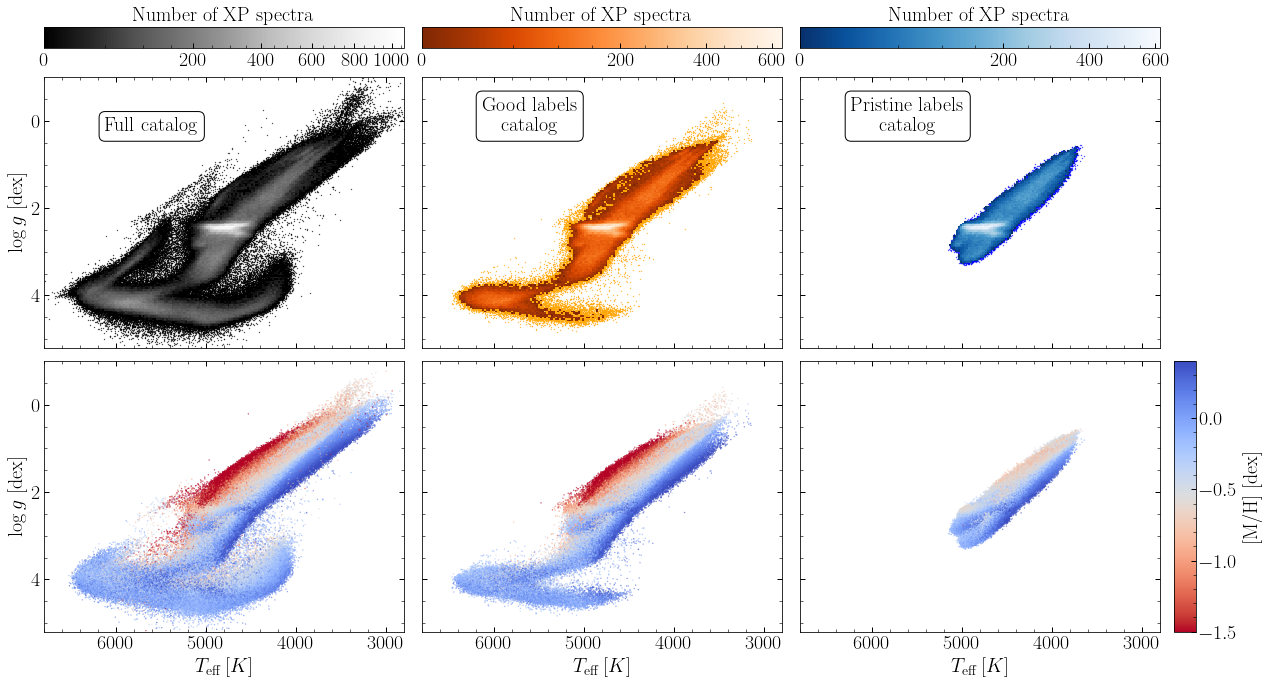

In [10]:
fig,ax = plt.subplots(2,3,figsize=(20,10),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0.05,wspace=0.05)

bins=201
teff_grid = np.linspace(min(teff),max(teff),bins)
logg_grid = np.linspace(min(logg),max(logg),bins)

# full catalog
im1 = ax[0,0].hist2d(teff,logg,bins=[teff_grid,logg_grid],cmin=20,norm=colors.PowerNorm(0.5),cmap='Greys_r',zorder=2)
ax[0,0].scatter(teff,logg,s=0.1,color='k',zorder=1)
im4 = ax[1,0].scatter(teff,logg,c=m_h,cmap='coolwarm_r',s=0.1,vmin=-1.5,vmax=0.4)

# good labels catalog
im2 = ax[0,1].hist2d(teff[good_idx],logg[good_idx],bins=[teff_grid,logg_grid],cmin=10,norm=colors.PowerNorm(0.5),cmap='Oranges_r',zorder=2)
ax[0,1].scatter(teff[good_idx],logg[good_idx],s=0.1,color='orange',zorder=1)
ax[1,1].scatter(teff[good_idx],logg[good_idx],c=m_h[good_idx],cmap='coolwarm_r',s=0.1,vmin=-1.5,vmax=0.4)

# pristine labels catalog
im3 = ax[0,2].hist2d(teff[pristine_idx],logg[pristine_idx],bins=[teff_grid,logg_grid],cmin=5,norm=colors.PowerNorm(0.5),cmap='Blues_r',zorder=2)
ax[0,2].scatter(teff[pristine_idx],logg[pristine_idx],s=0.1,color='blue',zorder=1)
ax[1,2].scatter(teff[pristine_idx],logg[pristine_idx],c=m_h[pristine_idx],cmap='coolwarm_r',s=0.1,vmin=-1.5,vmax=0.4)

for i,im in enumerate([im1,im2,im3]):
    pi =  ax[0,i].get_position().get_points().flatten()
    ax_cbar_i = fig.add_axes([pi[0], .92, pi[2]-pi[0], 0.03])
    cbar_i = plt.colorbar(im[3], cax=ax_cbar_i, orientation='horizontal')
    cbar_i.ax.set_title('Number of XP spectra')

pi = ax[1,2].get_position().get_points().flatten()
ax_cbar_i = fig.add_axes([.91, pi[1], 0.015, pi[3]-pi[1]])
cbar_i = plt.colorbar(im4, cax=ax_cbar_i, orientation='vertical')
cbar_i.ax.set_ylabel('[M/H] [dex]')

for axi in ax.flatten():
    axi.set_xlim(6800,2800)
    axi.set_ylim(5.2,-1)

ax[0,0].set_ylabel(r'$\log g$ [dex]')
ax[1,0].set_ylabel(r'$\log g$ [dex]')
ax[1,0].set_xlabel(r'$T_{\rm eff}\,[K]$')
ax[1,1].set_xlabel(r'$T_{\rm eff}\,[K]$')
ax[1,2].set_xlabel(r'$T_{\rm eff}\,[K]$')

bbox=dict(facecolor='none', edgecolor='k', boxstyle='round')

ax[0,0].text(.3,.8,'Full catalog',horizontalalignment='center',transform=ax[0,0].transAxes,fontsize=20,bbox=bbox)
ax[0,1].text(.3,.8,'Good labels\ncatalog',horizontalalignment='center',transform=ax[0,1].transAxes,fontsize=20,bbox=bbox)
ax[0,2].text(.3,.8,'Pristine labels\ncatalog',horizontalalignment='center',transform=ax[0,2].transAxes,fontsize=20,bbox=bbox)

plt.savefig('../figures/catalog_kiel.png',dpi=400,bbox_inches='tight')
plt.show()